In [2]:
import sys
sys.path.append("../Simulations/")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad, quad
from scipy.interpolate import interp1d
from scipy.special import erf, jn, jv, kn
import mpmath as mp
from skmonaco import mcimport, mcquad, mcmiser
import matplotlib as mpl

from units import *
from spec_calc import PowerSpectra, PowerSpectraPopulations
from astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

%matplotlib inline
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'units'

In [ ]:
mpl.rcParams['axes.linewidth'] = 1. #set the value globally
mpl.rcParams['figure.figsize'] = 6, 5

alpha_plot = 0.8
lw_plot = 2.5
colors_plot = ['dodgerblue', 'orange', 'mediumorchid']

In [ ]:
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

# Sensitivity to compact objects

In [50]:
pspecpop = PowerSpectraPopulations()

Loading Burkert parameters
Loading NFW parameters
Calculating velocity integrals


In [51]:
pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-3*kpc, R_max=260*kpc)

In [52]:
def get_f_DM_lim(M_DM=1e8*M_s, R0_DM=0, sigma_mu = 1, sigma_alpha = .1, N_q = 1e9):
    

    pspecpop.set_mass_distribution_compact(M_DM=M_DM, f_DM=1,R0_DM=R0_DM)
    pspecpop.get_C_l_compact_total_ary();


    fDM_base = 0
    dfDM_base = 0.1

    Cl_ary_fid = np.array(pspecpop.C_l_ary)*fDM_base

    p = np.array(pspecpop.C_l_ary)*(fDM_base + dfDM_base)
    m = np.array(pspecpop.C_l_ary)*(fDM_base - dfDM_base)

    fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                    None, None, '$\\f_\mathrm{DM}$' )

    parameters = [Cl_ary_fid, None, 1, 2000, fDM]
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q=N_q, l_min_mu=10, l_max_mu=2000, l_min_alpha=10, l_max_alpha=2000)

    fshr = FisherForecast(parameters, observation)
    lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])

    return lim

In [53]:
M_DM_ary = np.logspace(1,14,20)*M_s

f_DM_lim_1_ary = [get_f_DM_lim(M_DM, sigma_mu=1, sigma_alpha=1, N_q=1e9) for M_DM in tqdm_notebook(M_DM_ary)]
f_DM_lim_2_ary = [get_f_DM_lim(M_DM, sigma_mu=10, sigma_alpha=1, N_q=1e8) for M_DM in tqdm_notebook(M_DM_ary)]

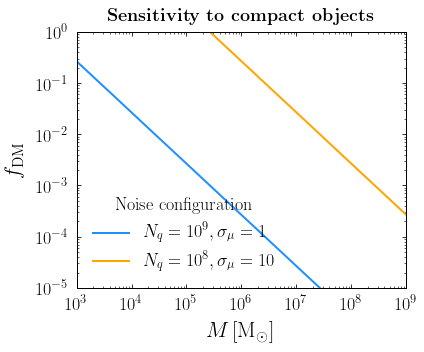

In [54]:
plt.plot(M_DM_ary/M_s, f_DM_lim_1_ary, label='$N_q = 10^9, \sigma_\mu=1$', color=colors_plot[0])
plt.plot(M_DM_ary/M_s, f_DM_lim_2_ary, label='$N_q = 10^8, \sigma_\mu=10$', color=colors_plot[1])

plt.xscale("log")
plt.yscale("log")

plt.ylim(1e-5,1)
plt.xlim(1e3, 1e9)

plt.xlabel("$M$\,[M$_\odot$]")
plt.ylabel("$f_\mathrm{DM}$")

plt.title('\\textbf{Sensitivity to compact objects}', y = 1.02, fontsize=18)
legend = plt.legend(frameon=False, title="Noise configuration")
plt.setp(legend.get_title(),fontsize=18)

plt.tight_layout()
plt.savefig("../Plots/compact.pdf")

In [93]:
R0_DM_ary = np.logspace(np.log10(0.1), np.log10(2000), 100)*pc

f_DM_lim_3_ary = [get_f_DM_lim(M_DM=1e6*M_s, R0_DM=R0_DM, sigma_mu=1, sigma_alpha=1, N_q=1e9) for R0_DM in tqdm_notebook(R0_DM_ary)]

In [99]:
f_DM_lim_4_ary = [get_f_DM_lim(M_DM=1e8*M_s, R0_DM=R0_DM, sigma_mu=1, sigma_alpha=1, N_q=1e9) for R0_DM in tqdm_notebook(R0_DM_ary)]

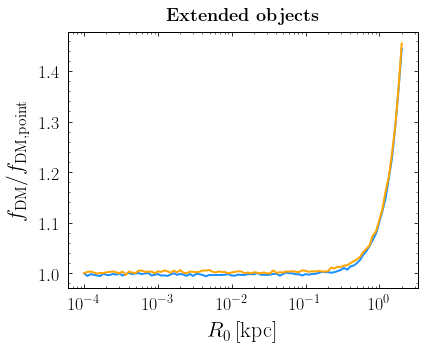

In [101]:
plt.plot(R0_DM_ary/kpc, (np.array(f_DM_lim_3_ary)/f_DM_lim_3_ary[0]), color=colors_plot[0])
plt.plot(R0_DM_ary/kpc, (np.array(f_DM_lim_4_ary)/f_DM_lim_4_ary[0]), color=colors_plot[1])

plt.ylabel("$f_{\mathrm{DM}}/f_\mathrm{DM, point}$")
plt.xlabel("$R_0$\,[kpc]")

plt.xscale("log")

plt.title('\\textbf{Extended objects}', y = 1.02, fontsize=18)

plt.tight_layout()
plt.savefig("../Plots/extended.pdf")